## Question 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy
import IPython.display as ipd
import math

### Reading the data

In [2]:
# reading the data
for i in range(1, 21):
    if i == 1:
        X, sr = librosa.load('./data/x_ica_'+str(i)+'.wav')
        signal_len = X.shape[0]
        X = X.reshape((1, signal_len))
    else:
#         X, sr = librosa.load('./data/x_ica_'+str(i)+'.wav')
        X = np.concatenate((X, librosa.load('./data/x_ica_'+str(i)+'.wav')[0].reshape((1, signal_len))), axis=0)
print(X.shape)

(20, 105840)


### standardization

In [3]:
X_standardized = np.subtract(X , X.mean(axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)
# print(X_standardized.mean(axis=1), X_standardized.std(axis=1))
# print(np.corrcoef(X_standardized))

### Dimensionality reduction

 eigen decomposition of hermitian full rank matix (cov_x) will result in eigen vectors that are orthogonal

In [4]:
# eigen decomposition "power iteration"
def power_iteration(A):
    """
    Ideally choose a random vector to decrease the chance that our vector is orthogonal to eigen vector
    """
    b_k = np.random.rand(A.shape[0])

    for i in range(1000):
        # compute the projection of vector onto the matirx A
        b_k1 = np.dot(A,b_k)
        # normalize the projection
        b_k1_norm = np.linalg.norm(b_k1)
        b_k = b_k1/b_k1_norm
    
    
    # rayleigh quotient in order to get the associated eigen value
    eigen_value = np.dot(b_k.T, np.dot(A, b_k))/np.dot(b_k.T,b_k)
    
    eigen_vector = np.reshape(b_k, (1, b_k.shape[0]))    
    
    # return eigen vector and eigen value
    return eigen_vector, eigen_value  

In [16]:
cov_x = np.cov(X_standardized) 
residual_cov = cov_x
cov_x_eigen_values = []

for i in range(20):
    
    eigen_vector, eigen_value = power_iteration(residual_cov)
    residual_cov = residual_cov - ((eigen_value)*np.dot(eigen_vector.T, eigen_vector))
    cov_x_eigen_values.append(eigen_value)
    if i == 0:
        cov_x_eigen_vector_matrix = eigen_vector.T
    else:
        cov_x_eigen_vector_matrix = np.concatenate((cov_x_eigen_vector_matrix, eigen_vector.T), axis=1)

cov_x_eigen_value_matrix = np.diag(cov_x_eigen_values)

### Power iteration alternative

In [17]:
# cov_x_eigen_values, cov_x_eigen_vector_matrix = np.linalg.eig(np.cov(X_standardized))

### plot the eigen values

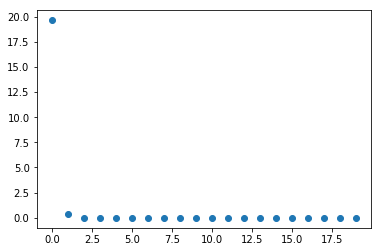

In [18]:
plt.scatter(np.arange(20), cov_x_eigen_values)
plt.show()

### selecting first n eigen values and eigen vectors. (PCA)
whitening using the eigen vectors and 1/sqrt(eigen values)

In [19]:
n = 3
eigen_select = [i for i in range(n)]
cov_x_eigen_value_matrix = np.diag([1/math.sqrt(i) for i in cov_x_eigen_values[:n]])

X_whitened_dim_red = np.dot(X_standardized.T, np.dot(cov_x_eigen_vector_matrix[:,eigen_select], cov_x_eigen_value_matrix)).T
np.cov(X_whitened_dim_red)

array([[  1.00000000e+00,   7.05044436e-15,   9.18534617e-12],
       [  7.05044436e-15,   1.00000000e+00,   1.59143910e-13],
       [  9.18534617e-12,   1.59143910e-13,   1.00000000e+00]])

### ICA

In [20]:
N = np.shape(X_whitened_dim_red)[1]
Z = X_whitened_dim_red
learning_rate = 0.000001
W = np.random.rand(n,n)
# W = np.ones((n,n))
Y = np.dot(W, Z)

def g(Y):
    return np.tanh(Y)

def f(Y):
    return np.power(Y, 3)

for i in range(1000):
#     print(Y)
#     print(g(Y))
#     print(f(Y))
    delta_w = np.dot((N*np.identity(n) - np.dot(g(Y), f(Y).T)), W)
#     print(delta_w)
    W = W + (learning_rate * delta_w)
    Y = np.dot(W, Z)

In [21]:
ipd.Audio(Y[0,:], rate=sr)

In [22]:
ipd.Audio(Y[1,:], rate=sr)

In [23]:
ipd.Audio(Y[2,:], rate=sr)